# Classifying Adverse Drug Events (ADEs)

In [23]:
import pandas as pd
from datasets import load_dataset
import re
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import spacy
from IPython.display import display, HTML

In [24]:
# Load dataset 
dataset = load_dataset("SetFit/ade_corpus_v2_classification")
df = dataset['train'].to_pandas()
df.head()

Repo card metadata block was not found. Setting CardData to empty.


,text,label,label_text
0,"On cessation of the injections, the retrocorne...",0,Not-Related
1,Median patient age was 52 years.,0,Not-Related
2,A whole brain irradiation was performed for 37...,0,Not-Related
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related
4,The fastidious organism grew only on buffered ...,0,Not-Related


### EDA

In [25]:
# Dataset size (observations and features)
n_obs, n_features = df.shape
print(f"Dataset size: {n_obs} observations, {n_features} features")

Dataset size: 17637 observations, 3 features


In [26]:
# Count of adverse drug events (label=1) vs non–adverse events (label=0)
n_ade = (df["label"] == 1).sum()
n_non_ade = (df["label"] == 0).sum()
print(f"Adverse drug events (label=1): {n_ade}")
print(f"Non–adverse events (label=0): {n_non_ade}")

Adverse drug events (label=1): 5145
Non–adverse events (label=0): 12492


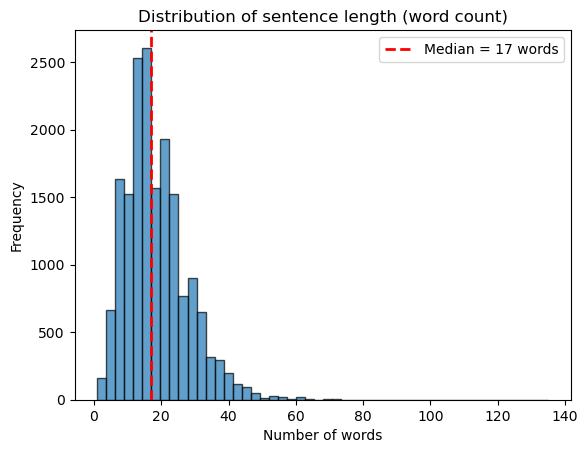

In [27]:
# Histogram of number of words per text, with median
import matplotlib.pyplot as plt

word_counts = df["text"].str.split().str.len()
median_words = word_counts.median()

fig, ax = plt.subplots()
ax.hist(word_counts, bins=50, edgecolor="black", alpha=0.7)
ax.axvline(median_words, color="red", linestyle="--", linewidth=2, label=f"Median = {median_words:.0f} words")
ax.set_xlabel("Number of words")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of sentence length (word count)")
ax.legend()
plt.show()

### Text Preprocessing

In [28]:
# Download NLTK data files
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucaspenney/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lucaspenney/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lucaspenney/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [29]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Uses Penn Treebank POS tags to map parts of speech for better lemmatization with WordNet
def _get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN  


def preprocess_text(text):
    """Lowercase, normalize whitespace, tokenize, remove punctuation/digits-only tokens, and lemmatize (POS-aware)."""
    if not isinstance(text, str) or not text.strip():
        return ''
    # Lowercase and normalize whitespace
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove tokens that are only punctuation/digits
    tokens = [t for t in tokens if re.search(r'[a-z]', t)]
    if not tokens:
        return ''

    # POS tag for better lemmatization
    pos_tags = pos_tag(tokens)
    lemmatized = [
        lemmatizer.lemmatize(token, pos=_get_wordnet_pos(tag))
        for token, tag in pos_tags
    ]
    return ' '.join(lemmatized)


df['processed_text'] = df['text'].apply(preprocess_text)
df.head()

,text,label,label_text,processed_text
0,"On cessation of the injections, the retrocorne...",0,Not-Related,on cessation of the injection the retrocorneal...
1,Median patient age was 52 years.,0,Not-Related,median patient age be year
2,A whole brain irradiation was performed for 37...,0,Not-Related,a whole brain irradiation be perform for 37.5g...
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related,complex biochemical syndrome of hypocalcemia a...
4,The fastidious organism grew only on buffered ...,0,Not-Related,the fastidious organism grow only on buffer ch...


### Information Extraction (NER)
- Use the scispaCy BC5CDR model to extract chemicals and diseases from the raw 'text' column
- These chemicals and diseases can be used as extra information for a classification model

In [30]:
# scispaCy BC5CDR model: CHEMICAL (drugs) and DISEASE (conditions/adverse effects)
nlp = spacy.load("en_ner_bc5cdr_md")


def extract_ner_entities(text):
    """Extract drug (chemical) and disease/condition entities from text using scispaCy NER."""
    if not isinstance(text, str) or not text.strip():
        return [], []
    doc = nlp(text)
    drugs = [ent.text for ent in doc.ents if ent.label_ == "CHEMICAL"]
    diseases = [ent.text for ent in doc.ents if ent.label_ == "DISEASE"]
    return drugs, diseases


# Copy df and add NER-derived columns
df_ner = df.copy()
ner_results = df_ner["text"].apply(extract_ner_entities)
df_ner["drug_entities"] = [r[0] for r in ner_results]
df_ner["disease_entities"] = [r[1] for r in ner_results]

df_ner.head()

,text,label,label_text,processed_text,drug_entities,disease_entities
0,"On cessation of the injections, the retrocorne...",0,Not-Related,on cessation of the injection the retrocorneal...,[],[]
1,Median patient age was 52 years.,0,Not-Related,median patient age be year,[],[]
2,A whole brain irradiation was performed for 37...,0,Not-Related,a whole brain irradiation be perform for 37.5g...,"[gefitinib, erlotinib]",[]
3,Complex biochemical syndrome of hypocalcemia a...,0,Not-Related,complex biochemical syndrome of hypocalcemia a...,[],"[hypocalcemia, hypoparathyroidism, leukemia]"
4,The fastidious organism grew only on buffered ...,0,Not-Related,the fastidious organism grow only on buffer ch...,[charcoal yeast extract],[]


#### NER Validation
- Taking samples of text and visualizing how the scispaCy model is classifying diseases and chemicals

In [31]:
from spacy import displacy
# Select a few random examples
sample_docs = df_ner[df_ner['drug_entities'].map(len) > 0].sample(5)['text']

for text in sample_docs:
    doc = nlp(text)
    
    # 1. Generate the HTML string with jupyter=False
    html = displacy.render(doc, style="ent", jupyter=False)
    
    # 2. Manually display the HTML using the correct import
    display(HTML(html))
    
    print("---")

---


---


---


---


---


## Classification Modeling

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
class NERFeatureExtractor(BaseEstimator, TransformerMixin):
    # Custom transformer to extract NER-based features
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Extract NER features from dataframe
        features = []
        for _, row in X.iterrows():
            # Binary features for presence of drugs/diseases
            has_drug = 1 if len(row['drug_entities']) > 0 else 0
            has_disease = 1 if len(row['disease_entities']) > 0 else 0
            
            # Count features
            drug_count = len(row['drug_entities'])
            disease_count = len(row['disease_entities'])
            
            # Combined feature: presence of both drug and disease
            has_both = 1 if (has_drug and has_disease) else 0
            
            features.append([has_drug, has_disease, drug_count, disease_count, has_both])
        
        return np.array(features)

# Prepare the data for modeling
df_model = df_ner.copy()

# Create features: text + NER features
X_text = df_model['processed_text'].values
X_ner_features = df_model[['drug_entities', 'disease_entities']]
y = df_model['label'].values

print(f"Dataset shape: {df_model.shape}")
print(f"Positive samples (ADE): {y.sum()}")
print(f"Negative samples: {len(y) - y.sum()}")

Dataset shape: (17637, 6)
Positive samples (ADE): 5145
Negative samples: 12492


In [34]:
# BASELINE MODELS
# Split data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")

# Define baseline models
baseline_models = {
    'Naive Bayes': GaussianNB(),  # Using Gaussian NB for continuous TF-IDF features
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='linear', random_state=42, probability=True)
}

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

# Transform text data
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# Train and evaluate baseline models
baseline_results = {}
for name, model in baseline_models.items():
    # GaussianNB requires dense arrays, convert sparse TF-IDF to dense
    if isinstance(model, GaussianNB):
        X_train_features = X_train_tfidf.toarray()
        X_test_features = X_test_tfidf.toarray()
    else:
        X_train_features = X_train_tfidf
        X_test_features = X_test_tfidf
    
    # Train model
    model.fit(X_train_features, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_features)
    y_pred_proba = model.predict_proba(X_test_features)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    baseline_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': model
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

Training samples: 14109
Test samples: 3528

Naive Bayes:
  Accuracy: 0.6845
  Precision: 0.4780
  Recall: 0.8853
  F1-Score: 0.6208

Logistic Regression:
  Accuracy: 0.8552
  Precision: 0.8381
  Recall: 0.6239
  F1-Score: 0.7153

Random Forest:
  Accuracy: 0.8730
  Precision: 0.8654
  Recall: 0.6686
  F1-Score: 0.7544

KNN:
  Accuracy: 0.7707
  Precision: 0.8873
  Recall: 0.2449
  F1-Score: 0.3839

SVM:
  Accuracy: 0.8741
  Precision: 0.8204
  Recall: 0.7279
  F1-Score: 0.7714


In [35]:
# Prepare combined dataset with NER features
X_combined = df_model[['processed_text', 'drug_entities', 'disease_entities']]
X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Custom transformer for combined features
class CombinedFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
        self.ner_extractor = NERFeatureExtractor()
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        # Fit TF-IDF on text
        self.tfidf.fit(X['processed_text'])
        
        # Fit scaler on NER features
        ner_features = self.ner_extractor.transform(X)
        self.scaler.fit(ner_features)
        
        return self
    
    def transform(self, X):
        # Transform text
        text_features = self.tfidf.transform(X['processed_text'])
        
        # Transform NER features
        ner_features = self.ner_extractor.transform(X)
        ner_features_scaled = self.scaler.transform(ner_features)
        
        # Combine features
        from scipy.sparse import hstack
        return hstack([text_features, ner_features_scaled])

# Create pipeline with combined features
combined_models = {
    'Naive Bayes (NER)': GaussianNB(),
    'Logistic Regression (NER)': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest (NER)': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN (NER)': KNeighborsClassifier(n_neighbors=5),
    'SVM (NER)': SVC(kernel='linear', random_state=42, probability=True)
}

# Custom transformer to convert sparse to dense for models that require it
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert sparse matrix to dense array
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

combined_results = {}
for name, model in combined_models.items():
    # GaussianNB requires dense arrays, add densifier to pipeline
    if isinstance(model, GaussianNB):
        pipeline = Pipeline([
            ('features', CombinedFeaturesTransformer()),
            ('densify', DenseTransformer()),
            ('classifier', model)
        ])
    else:
        pipeline = Pipeline([
            ('features', CombinedFeaturesTransformer()),
            ('classifier', model)
        ])
    
    # Train
    pipeline.fit(X_train_combined, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test_combined)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    combined_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': pipeline
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")


Naive Bayes (NER):
  Accuracy: 0.7160
  Precision: 0.5078
  Recall: 0.8562
  F1-Score: 0.6375

Logistic Regression (NER):
  Accuracy: 0.8818
  Precision: 0.8129
  Recall: 0.7726
  F1-Score: 0.7922

Random Forest (NER):
  Accuracy: 0.8954
  Precision: 0.8223
  Recall: 0.8183
  F1-Score: 0.8203

KNN (NER):
  Accuracy: 0.8424
  Precision: 0.7344
  Recall: 0.7201
  F1-Score: 0.7272

SVM (NER):
  Accuracy: 0.8900
  Precision: 0.8189
  Recall: 0.7998
  F1-Score: 0.8092


In [36]:
# NER-ONLY MODELS
# Train models using only NER-derived features (no text vectorization)
print("\n" + "="*50)
print("MODELS WITH NER FEATURES ONLY")
print("="*50)

# Extract NER features
ner_extractor = NERFeatureExtractor()
X_train_ner = ner_extractor.fit_transform(X_train_combined)
X_test_ner = ner_extractor.transform(X_test_combined)

# Scale NER features for better performance
scaler_ner = StandardScaler()
X_train_ner_scaled = scaler_ner.fit_transform(X_train_ner)
X_test_ner_scaled = scaler_ner.transform(X_test_ner)

# Define models appropriate for NER features
# These models work well with small feature sets
ner_only_models = {
    'Naive Bayes (NER)': GaussianNB(),  # Gaussian NB for continuous scaled features
    'Logistic Regression (NER)': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest (NER)': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (NER)': SVC(kernel='rbf', random_state=42, probability=True),  # RBF kernel for non-linear relationships
    'KNN (NER)': KNeighborsClassifier(n_neighbors=5)
}

ner_only_results = {}
for name, model in ner_only_models.items():
    # Train model
    model.fit(X_train_ner_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_ner_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    ner_only_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': model
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")


MODELS WITH NER FEATURES ONLY

Naive Bayes (NER):
  Accuracy: 0.7874
  Precision: 0.6084
  Recall: 0.7609
  F1-Score: 0.6762

Logistic Regression (NER):
  Accuracy: 0.7914
  Precision: 0.6160
  Recall: 0.7561
  F1-Score: 0.6789

Random Forest (NER):
  Accuracy: 0.7985
  Precision: 0.6893
  Recall: 0.5627
  F1-Score: 0.6196

SVM (NER):
  Accuracy: 0.7993
  Precision: 0.6895
  Recall: 0.5675
  F1-Score: 0.6226

KNN (NER):
  Accuracy: 0.7809
  Precision: 0.6081
  Recall: 0.6997
  F1-Score: 0.6507


/var/folders/t6/20snxlwd43x0kqt3422zqb840000gn/T/ipykernel_48087/2463402883.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/t6/20snxlwd43x0kqt3422zqb840000gn/T/ipykernel_48087/2463402883.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/t6/20snxlwd43x0kqt3422zqb840000gn/T/ipykernel_48087/2463402883.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/t6/20snxlwd43x0kqt3422zqb840000gn/T/ipykernel_48087/2463402883.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

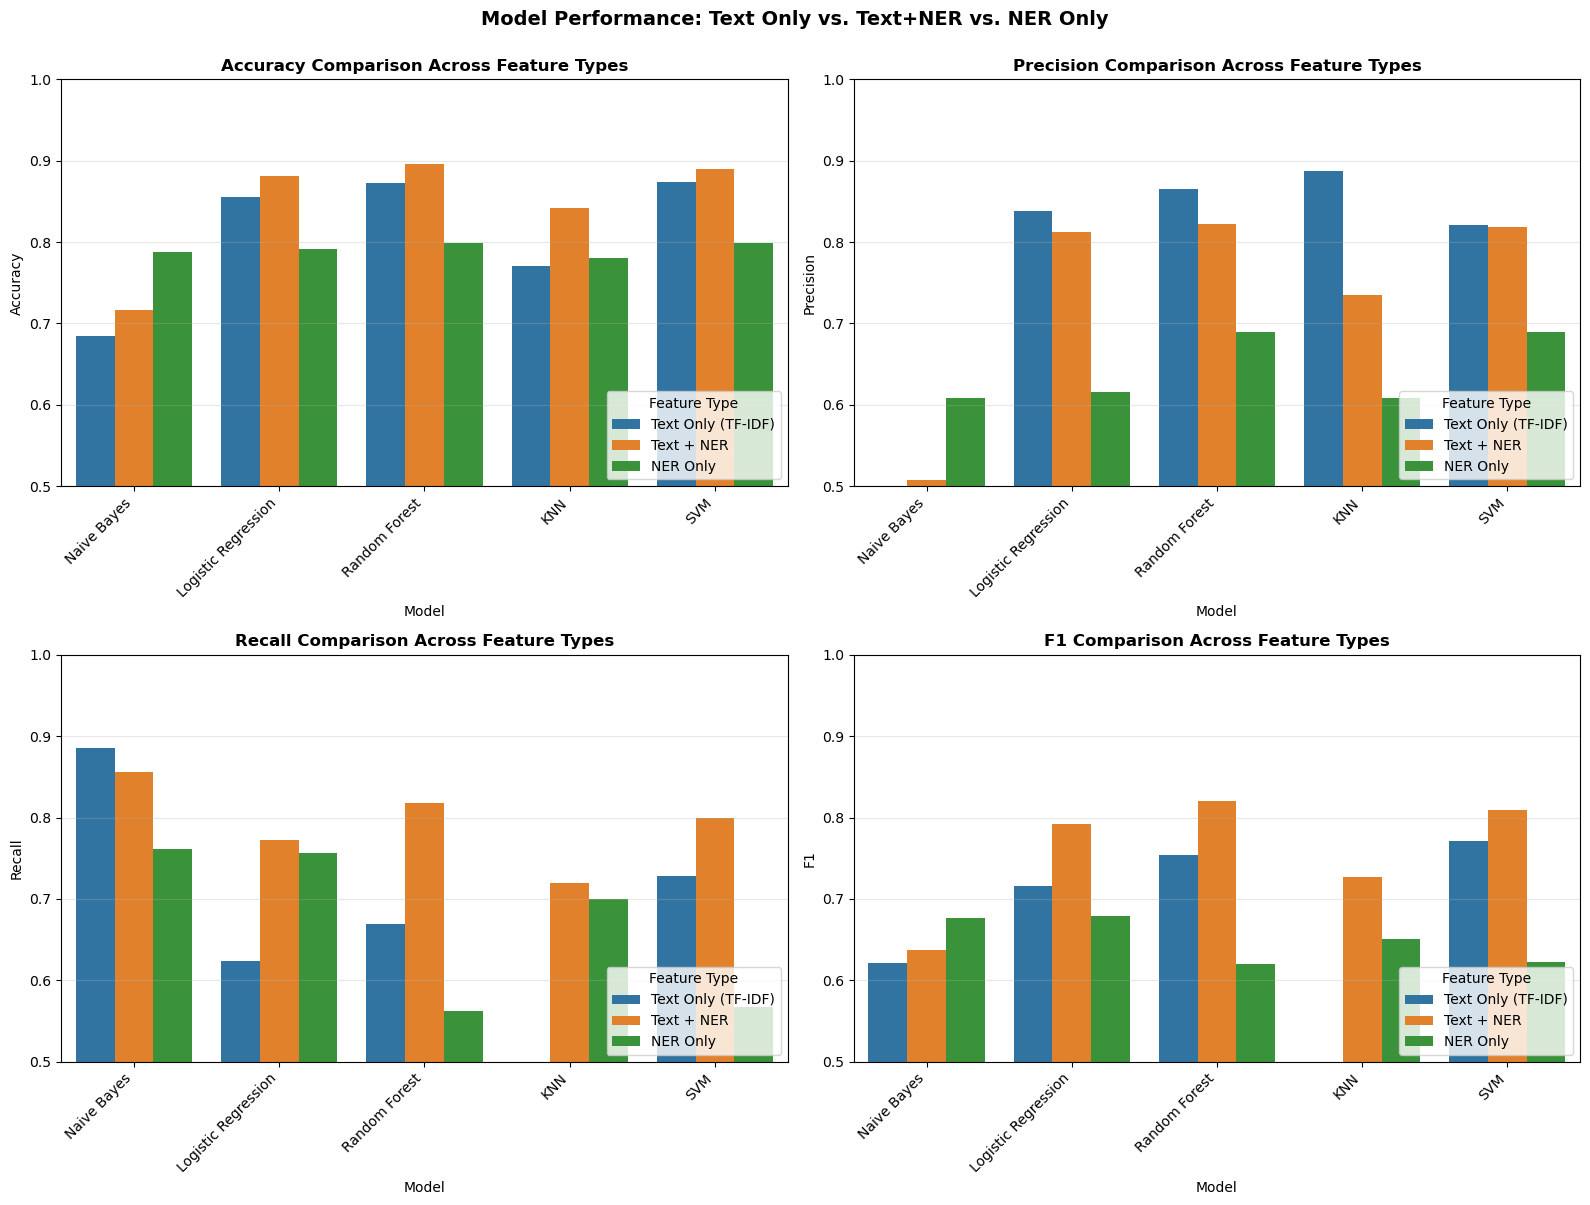

In [37]:
# Compare all three types of models: Baseline (text only), Combined (text + NER), NER-only
comparison_data = []

# Baseline models (text only)
for name, results in baseline_results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1': results['f1'],
        'Type': 'Text Only (TF-IDF)'
    })

# Combined models (text + NER)
for name, results in combined_results.items():
    model_base = name.replace(' (NER)', '')
    comparison_data.append({
        'Model': model_base,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1': results['f1'],
        'Type': 'Text + NER'
    })

# NER-only models
for name, results in ner_only_results.items():
    model_base = name.replace(' (NER)', '')
    comparison_data.append({
        'Model': model_base,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1': results['f1'],
        'Type': 'NER Only'
    })

comparison_df = pd.DataFrame(comparison_data)

# Visualize comparison - all three types
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    sns.barplot(data=comparison_df, x='Model', y=metric, hue='Type', ax=ax)
    ax.set_title(f'{metric} Comparison Across Feature Types', fontsize=12, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0.5, 1.0)
    ax.legend(title='Feature Type', loc='lower right')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Model Performance: Text Only vs. Text+NER vs. NER Only', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [38]:
# Summary statistics by feature type
print("\n" + "="*70)
print("SUMMARY: AVERAGE PERFORMANCE BY FEATURE TYPE")
print("="*70)

summary_stats = comparison_df.groupby('Type')[['Accuracy', 'Precision', 'Recall', 'F1']].agg(['mean', 'std'])
print(summary_stats.round(4))

# Best model for each type
print("\n" + "="*70)
print("BEST MODEL FOR EACH FEATURE TYPE")
print("="*70)

for feature_type in ['Text Only (TF-IDF)', 'Text + NER', 'NER Only']:
    subset = comparison_df[comparison_df['Type'] == feature_type]
    best_idx = subset['F1'].idxmax()
    best_row = subset.loc[best_idx]
    print(f"\n{feature_type}:")
    print(f"  Best Model: {best_row['Model']}")
    print(f"  Accuracy: {best_row['Accuracy']:.4f}")
    print(f"  Precision: {best_row['Precision']:.4f}")
    print(f"  Recall: {best_row['Recall']:.4f}")
    print(f"  F1-Score: {best_row['F1']:.4f}")


SUMMARY: AVERAGE PERFORMANCE BY FEATURE TYPE
                   Accuracy         Precision          Recall              F1  \
                       mean     std      mean     std    mean     std    mean   
Type                                                                            
NER Only             0.7915  0.0077    0.6423  0.0431  0.6694  0.0982  0.6496   
Text + NER           0.8451  0.0751    0.7392  0.1344  0.7934  0.0510  0.7573   
Text Only (TF-IDF)   0.8115  0.0828    0.7778  0.1696  0.6301  0.2370  0.6491   

                            
                       std  
Type                        
NER Only            0.0283  
Text + NER          0.0761  
Text Only (TF-IDF)  0.1594  

BEST MODEL FOR EACH FEATURE TYPE

Text Only (TF-IDF):
  Best Model: SVM
  Accuracy: 0.8741
  Precision: 0.8204
  Recall: 0.7279
  F1-Score: 0.7714

Text + NER:
  Best Model: Random Forest
  Accuracy: 0.8954
  Precision: 0.8223
  Recall: 0.8183
  F1-Score: 0.8203

NER Only:
  Best Model: Logi


OVERALL BEST MODEL SELECTION

Best Overall Model: Random Forest (Text + NER)
  Accuracy: 0.8954
  Precision: 0.8223
  Recall: 0.8183
  F1-Score: 0.8203

Classification Report:
              precision    recall  f1-score   support

     Not ADE       0.93      0.93      0.93      2499
         ADE       0.82      0.82      0.82      1029

    accuracy                           0.90      3528
   macro avg       0.87      0.87      0.87      3528
weighted avg       0.90      0.90      0.90      3528



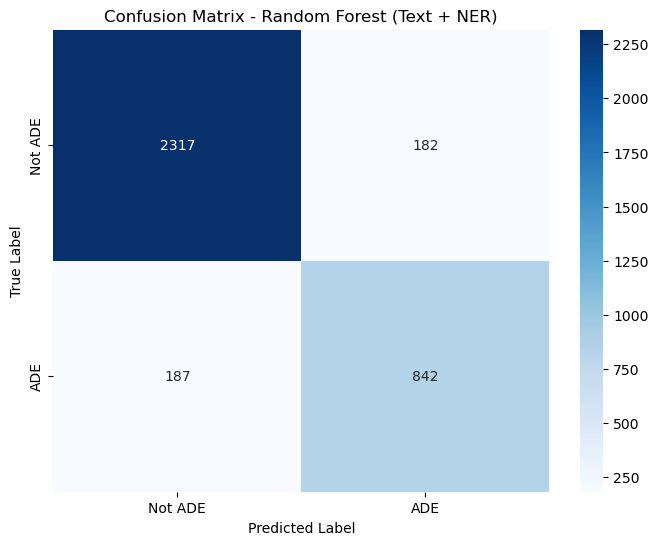

In [39]:
# Select overall best model based on F1-score across all types
print("\n" + "="*70)
print("OVERALL BEST MODEL SELECTION")
print("="*70)

best_idx = comparison_df['F1'].idxmax()
best_row = comparison_df.loc[best_idx]
best_feature_type = best_row['Type']

print(f"\nBest Overall Model: {best_row['Model']} ({best_feature_type})")
print(f"  Accuracy: {best_row['Accuracy']:.4f}")
print(f"  Precision: {best_row['Precision']:.4f}")
print(f"  Recall: {best_row['Recall']:.4f}")
print(f"  F1-Score: {best_row['F1']:.4f}")

# Get the actual model and data based on feature type
if best_feature_type == 'Text Only (TF-IDF)':
    best_model = baseline_results[best_row['Model']]['model']
    X_test_eval = X_test_tfidf
    if isinstance(best_model, GaussianNB):
        X_test_eval = X_test_tfidf.toarray()
    y_pred = best_model.predict(X_test_eval)
    y_pred_proba = best_model.predict_proba(X_test_eval)[:, 1]
elif best_feature_type == 'Text + NER':
    model_name = best_row['Model'] + ' (NER)'
    best_model = combined_results[model_name]['model']
    X_test_eval = X_test_combined
    y_pred = best_model.predict(X_test_eval)
    y_pred_proba = best_model.predict_proba(X_test_eval)[:, 1]
else:  # NER Only
    model_name = best_row['Model'] + ' (NER)'
    best_model = ner_only_results[model_name]['model']
    X_test_eval = X_test_ner_scaled
    y_pred = best_model.predict(X_test_eval)
    y_pred_proba = best_model.predict_proba(X_test_eval)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not ADE', 'ADE']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not ADE', 'ADE'], 
            yticklabels=['Not ADE', 'ADE'])
plt.title(f'Confusion Matrix - {best_row["Model"]} ({best_feature_type})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

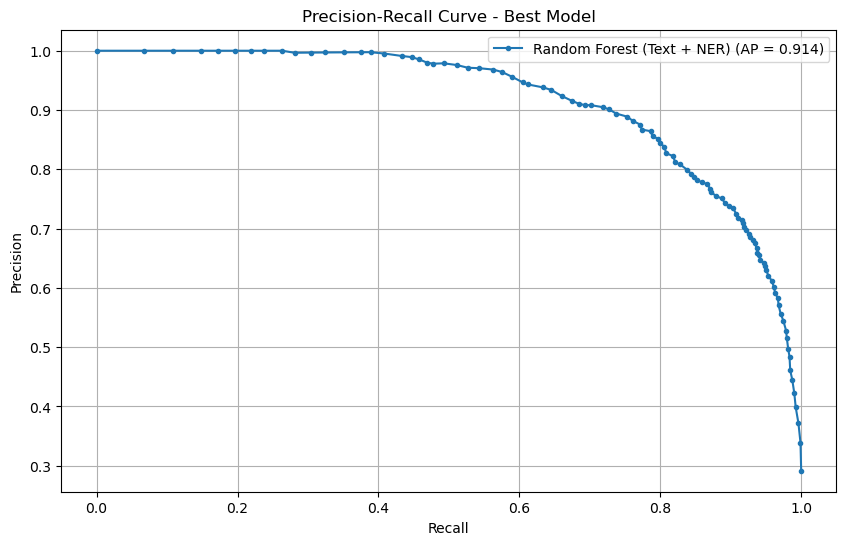

In [40]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall_curve, precision_curve, marker='.', 
         label=f'{best_row["Model"]} ({best_feature_type}) (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Best Model')
plt.legend()
plt.grid(True)
plt.show()


FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features for Random Forest (Text + NER):

 1. has_both                       : 0.077227
 2. drug_count                     : 0.057162
 3. has_drug                       : 0.053115
 4. disease_count                  : 0.033063
 5. induced                        : 0.025041
 6. has_disease                    : 0.019586
 7. develop                        : 0.014299
 8. associate                      : 0.009072
 9. induce                         : 0.007376
10. associated                     : 0.006650
11. report                         : 0.006423
12. case                           : 0.006006
13. patient                        : 0.005707
14. treatment                      : 0.005284
15. cause                          : 0.004337
16. therapy                        : 0.004288
17. acute                          : 0.004022
18. interferon                     : 0.003883
19. syndrome                       : 0.003731
20. administration              

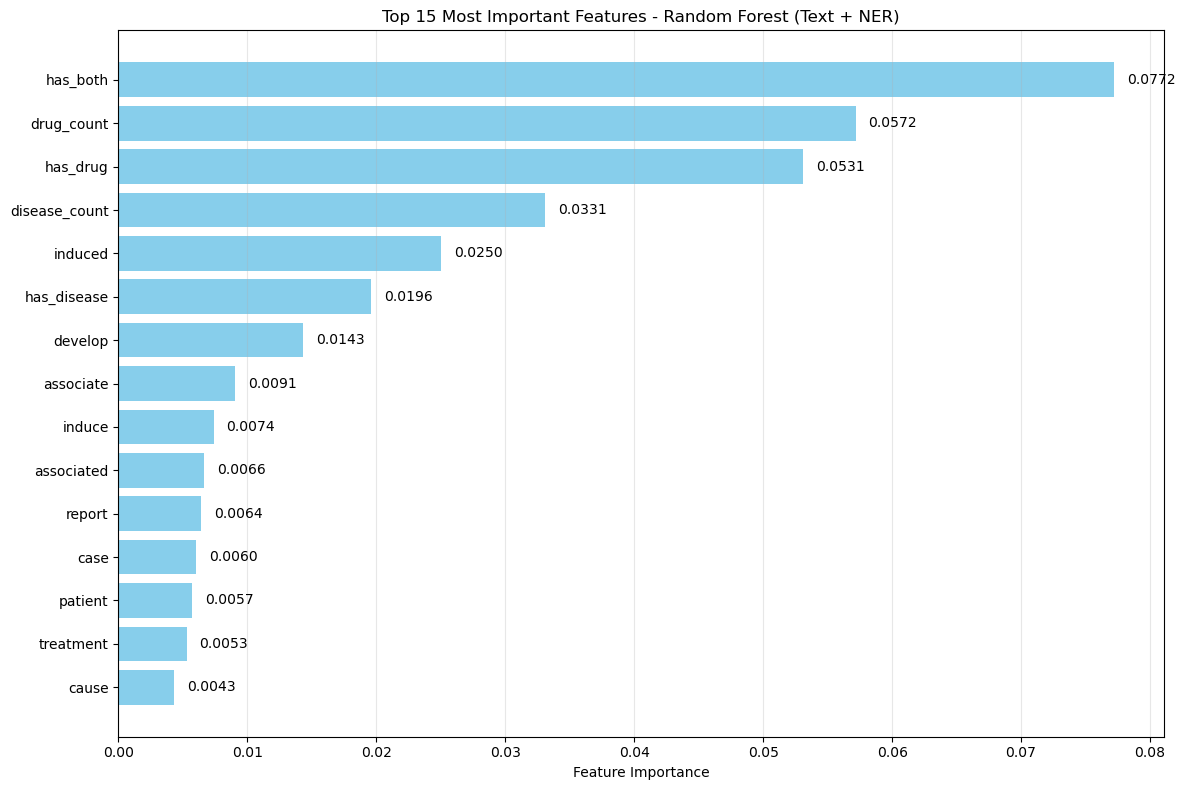


NER FEATURE IMPORTANCE

NER Feature Importances:
  has_drug             : 0.053115
  has_disease          : 0.019586
  drug_count           : 0.057162
  disease_count        : 0.033063
  has_both             : 0.077227


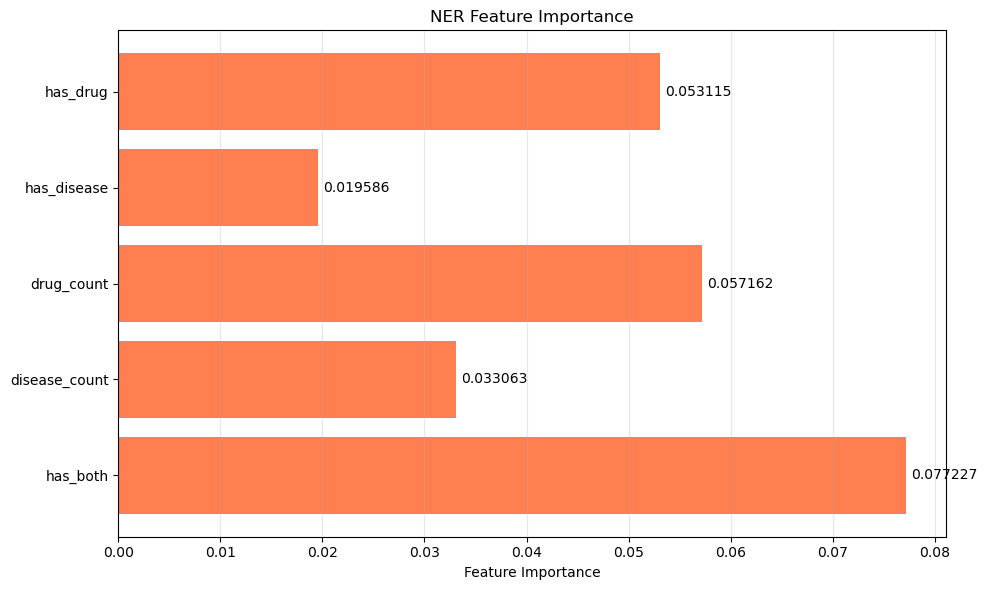

In [41]:
# FEATURE IMPORTANCE ANALYSIS
# Only applicable to tree-based models (Random Forest)
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

if 'Random Forest' in best_row['Model']:
    if best_feature_type == 'Text + NER':
        # Combined model with pipeline
        rf_model = best_model.named_steps['classifier']
        feature_importances = rf_model.feature_importances_
        
        # Get feature names
        text_feature_names = best_model.named_steps['features'].tfidf.get_feature_names_out()
        ner_feature_names = ['has_drug', 'has_disease', 'drug_count', 'disease_count', 'has_both']
        all_feature_names = list(text_feature_names) + ner_feature_names
        
    elif best_feature_type == 'NER Only':
        # NER-only model
        rf_model = best_model
        feature_importances = rf_model.feature_importances_
        all_feature_names = ['has_drug', 'has_disease', 'drug_count', 'disease_count', 'has_both']
        
    else:  # Text Only
        # Text-only model
        rf_model = best_model
        feature_importances = rf_model.feature_importances_
        all_feature_names = list(tfidf.get_feature_names_out())
    
    # Sort feature importances
    sorted_idx = np.argsort(feature_importances)[::-1]
    
    # Print top 20 features
    print(f"\nTop 20 Most Important Features for {best_row['Model']} ({best_feature_type}):\n")
    for i in range(min(20, len(sorted_idx))):
        idx = sorted_idx[i]
        feat_name = all_feature_names[idx] if idx < len(all_feature_names) else f'Feature_{idx}'
        print(f"{i+1:2d}. {feat_name:30s} : {feature_importances[idx]:.6f}")
    
    # Visualize top features
    top_n = min(15, len(feature_importances))
    top_indices = sorted_idx[:top_n]
    top_features = [all_feature_names[i] if i < len(all_feature_names) else f'Feature_{i}' for i in top_indices]
    top_importance = feature_importances[top_indices]
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(top_n), top_importance[::-1], color='skyblue')
    plt.yticks(range(top_n), top_features[::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Features - {best_row["Model"]} ({best_feature_type})')
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, top_importance[::-1])):
        plt.text(val + 0.001, bar.get_y() + bar.get_height()/2, 
                 f'{val:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # If NER features are present, show their specific importance
    if best_feature_type in ['Text + NER', 'NER Only']:
        print("\n" + "="*70)
        print("NER FEATURE IMPORTANCE")
        print("="*70)
        
        if best_feature_type == 'Text + NER':
            ner_start_idx = len(text_feature_names)
            ner_importances = feature_importances[ner_start_idx:]
        else:
            ner_importances = feature_importances
        
        ner_feature_names = ['has_drug', 'has_disease', 'drug_count', 'disease_count', 'has_both']
        
        print("\nNER Feature Importances:")
        for name, importance in zip(ner_feature_names, ner_importances):
            print(f"  {name:20s} : {importance:.6f}")
        
        # Visualize NER features
        plt.figure(figsize=(10, 6))
        bars = plt.barh(range(len(ner_feature_names)), ner_importances[::-1], color='coral')
        plt.yticks(range(len(ner_feature_names)), ner_feature_names[::-1])
        plt.xlabel('Feature Importance')
        plt.title('NER Feature Importance')
        plt.grid(axis='x', alpha=0.3)
        
        for i, (bar, val) in enumerate(zip(bars, ner_importances[::-1])):
            plt.text(val + 0.0005, bar.get_y() + bar.get_height()/2, 
                     f'{val:.6f}', va='center')
        
        plt.tight_layout()
        plt.show()
else:
    print(f"\nFeature importance analysis is only available for Random Forest models.")
    print(f"Best model is {best_row['Model']}, which does not provide feature importances.")